# Example of FGSM attack on a LeNet model trained on GTSRB dataset

In [1]:
#Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import train_classifier as tr
from dataloaders import gtsrb_loader
import copy
from attacks import fgsm
from models import lenet
from pruning import StructuredPruning
import os

# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda:0" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


# Structured Pruning

### Loading the model and data and setting the parameters

In [2]:
# Load a LeNet pre-trained model on GTSRB dataset
PATH = os.getcwd() + "/results/LeNet_GTSRB.pt"
checkpoint = torch.load(PATH, map_location=device)
model = lenet.LeNet(num_classes=43)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

#Set the training and test batch sizes for the data loader
batch_size_tr, batch_size_test = 128, 128

#Load training and test data
train_loader, test_loader = gtsrb_loader.get_loader(batch_size_tr, batch_size_test)


#Percentage of pruning percentages to explore
perc = [0, 0.1, 0.2, 0.3]
#Values of epsilon used for the FGSM attack
epsilon = [0, 4, 8, 12, 16]

#Placeholder to store the robust accuracy for different levels of pruning and attack strength
accuracies = torch.zeros((len(perc), len(epsilon)))

### Computing the clean accuracy

In [3]:
#First, we compute the clean accuracy (when there is no attack) for models with different amount of pruning
print("----------------------------------")
print("CLEAN ACCURACY")
print("----------------------------------")
#Clean accuracy for the model without pruning
print("PRUNING PERCENTAGE: 0%")
print("Accuracy after pruning: ")
acc_pruned = tr.get_accuracy(model, test_loader, device)
accuracies[0][0] = acc_pruned.cpu()
print(f'Test accuracy: {100 * acc_pruned:.3f}%')
#Clean accuracy of the pruned models
for i in range(len(perc)):
    if perc[i] == 0: continue 
    #Copy the original model before pruning
    model_pruned = copy.deepcopy(model).to(device)
    #Apply structured pruning
    StructuredPruning.StructuredPruning(model_pruned, perc[i])
    print("PRUNING PERCENTAGE: ", 100*perc[i], "%")
    acc_pruned = tr.get_accuracy(model_pruned, test_loader, device)
    accuracies[i][0] = acc_pruned.cpu()
    print(f'Test accuracy: {100 * acc_pruned:.3f}%')
    


----------------------------------
CLEAN ACCURACY
----------------------------------
PRUNING PERCENTAGE: 0%
Accuracy after pruning: 
Test accuracy: 92.011%
PRUNING PERCENTAGE:  10.0 %
Test accuracy: 91.964%
PRUNING PERCENTAGE:  20.0 %
Test accuracy: 73.729%
PRUNING PERCENTAGE:  30.0 %
Test accuracy: 62.771%


### Computing the Robust Accuracy

In [5]:
#Set the attack type to untargeted
attack_type = 'untargeted'

print("----------------------------------")
print("FGSM Attack")
print("----------------------------------")

# Run the attack on the whole test set for different values of epislon
for i in range(len(epsilon)):
    
    if epsilon[i] == 0: continue
    # Run the attack for models with different amount of pruning
    print("\nEPSILON: ", epsilon[i])
    for j in range(len(perc)):
        if perc[j] == 0:
            acc, _ = fgsm.test(model, device, test_loader, epsilon[i]/255, attack_type)
            accuracies[j][i] = acc
            print(f"Non-pruned model - Test Accuracy = {100*acc:.3f}%")
        else:
            model_pruned = copy.deepcopy(model).to(device)
            StructuredPruning.StructuredPruning(model_pruned, perc[j])
            print("PRUNING PERCENTAGE: ", 100*perc[j], "%")
            acc, _ = fgsm.test(model_pruned, device, test_loader, epsilon[i]/255, attack_type)
            accuracies[j][i] = acc
            print(f"Test Accuracy = {100*acc:.3f}%")

----------------------------------
FGSM Attack
----------------------------------

EPSILON:  4
Non-pruned model - Test Accuracy = 49.850%
PRUNING PERCENTAGE:  10.0 %
Test Accuracy = 50.333%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 38.876%
PRUNING PERCENTAGE:  30.0 %
Test Accuracy = 31.726%

EPSILON:  8
Non-pruned model - Test Accuracy = 36.730%
PRUNING PERCENTAGE:  10.0 %
Test Accuracy = 37.989%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 26.880%
PRUNING PERCENTAGE:  30.0 %
Test Accuracy = 23.056%

EPSILON:  12
Non-pruned model - Test Accuracy = 32.415%
PRUNING PERCENTAGE:  10.0 %
Test Accuracy = 34.466%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 21.948%
PRUNING PERCENTAGE:  30.0 %
Test Accuracy = 18.543%

EPSILON:  16
Non-pruned model - Test Accuracy = 30.404%
PRUNING PERCENTAGE:  10.0 %
Test Accuracy = 32.700%
PRUNING PERCENTAGE:  20.0 %
Test Accuracy = 19.113%
PRUNING PERCENTAGE:  30.0 %
Test Accuracy = 15.883%


### Plot the results

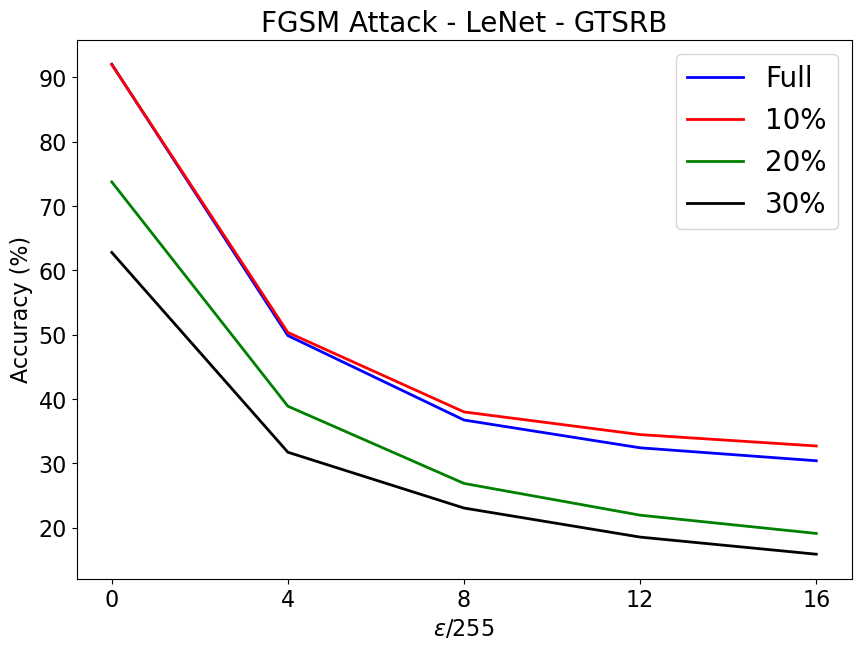

In [6]:
eps = np.array(epsilon)
accs = np.array(accuracies)*100
plt.figure(figsize=(10,7))
plt.plot(eps, accs[0,:],'b', linewidth=2)
plt.plot(eps, accs[1,:], 'r', linewidth=2)
plt.plot(eps, accs[2,:], 'g', linewidth=2)
plt.plot(eps, accs[3,:], 'k', linewidth=2)
plt.xlabel('$\epsilon$/255',fontsize=16)
plt.ylabel('Accuracy (%)',fontsize=16)
plt.legend(('Full', '10%', '20%', '30%'), fontsize=20)
plt.title('FGSM Attack - LeNet - GTSRB',fontsize=20)
plt.yticks(fontsize=16)
plt.xticks([0, 4, 8, 12, 16], fontsize=16)
plt.show()